In [72]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
from scipy.optimize import curve_fit

In [79]:
file = r'\\server\groups\ding\PROJECTS\QKD_Perovskites\TimeTagger\20251123\TimeTags_PW_2025-11-23_094143.ttbin'

In [80]:
fr = FileReader(file)
print("All channels available: {}".format(fr.getChannelList()))

print("Has data? ->", fr.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

All channels available: (4, 3)
Has data? -> True


In [81]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2025-11-23 09:41:43 +0100
devices: [{'PCB version': '1.7 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '22440012XD'}]
firmware version: TT-Ultra, FW 5, TS 2022-02-02 13:09:16, OK 1.46
fpga link: {'channels': [], 'enabled': False, 'interface': None}
hardware buffer size: 67108864
inputs: [{'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [5, 1], 'hardware delay compensation': [552, 552], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 8.0, 'trigger level': -0.01}, {'channel': [2, -2], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay sof

In [82]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

{'configure version': 1,
 'current time': '2025-11-24 10:10:12 +0100',
 'deprecated replay scheme': True,
 'hardware configuration': None,
 'measurements': [],
 'replay speed': -1.0,
 'software clock': None,
 'software version': '2.19.0',
 'virtual inputs': []}


Correlation measurement is running.

Rate of counts channel 3 (counts/sec) : 5275.566700633986
Total counts channel 3 : 2795996
Rate of counts channel 4 (counts/sec) : 4672.537997461335
Total counts channel 4 : 2476397


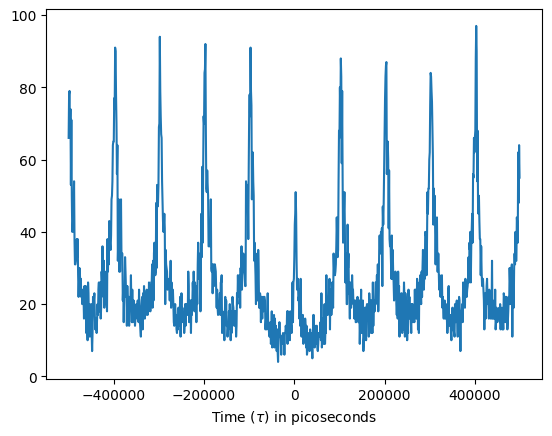

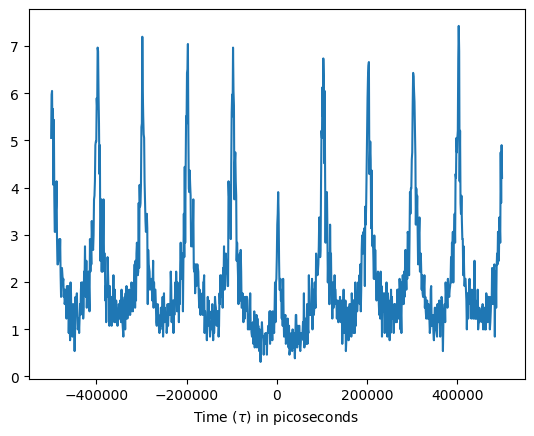

In [83]:
# measure photon antibunching
corr_ch1 = config['registered channels'][2] # first photon channel for antibunching measurements
corr_ch2 = config['registered channels'][3] # second photon channel for antibunching measurements
bwcorr = 1000 # 1 ns
nbins = 1000

corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])
print("\nCorrelation measurement is running.\n")


virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
#virtual_tagger.replay(file, duration=8*10e11) # collect only 1 sec. of data (duration in picoseconds)
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr = corr.getIndex()
ycorr_norm = corr.getDataNormalized()
ycorr = corr.getData()

rate_ch1 = cr.getData()[0]
rate_ch2 = cr.getData()[1]
counts_ch1 = cr.getCountsTotal()[0]
counts_ch2 = cr.getCountsTotal()[1]

print(f"Rate of counts channel {corr_ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Total counts channel {corr_ch1} : {cr.getCountsTotal()[0]}")
print(f"Rate of counts channel {corr_ch2} (counts/sec) : {cr.getData()[1]}")
print(f"Total counts channel {corr_ch2} : {cr.getCountsTotal()[1]}")

plt.plot(xcorr, ycorr)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

plt.plot(xcorr, ycorr_norm)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

## Data analysis

In [84]:
def plot_data(tau, counts, width=10, height=6):
    plt.figure(figsize=(width, height))
    plt.plot(tau/1000, counts, marker='o', linestyle='-', color='b', markersize=3, linewidth=0.7)
    # plt.title('Auto-correlation graph', fontsize=16)
    plt.xlabel('Time differences (ns)', fontsize=14)
    plt.ylabel('Counts per bin', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.show()

Capture duration (seconds):  529.989697536


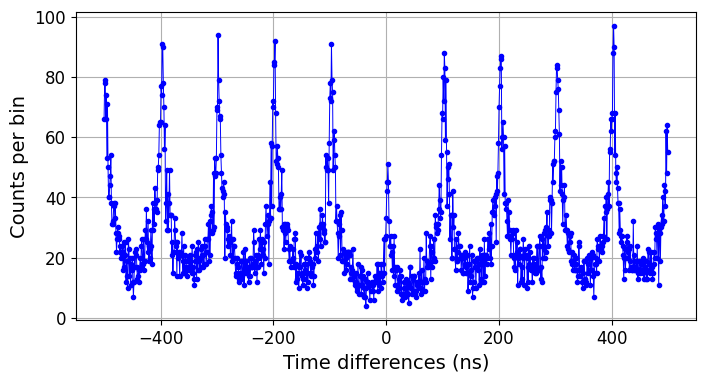

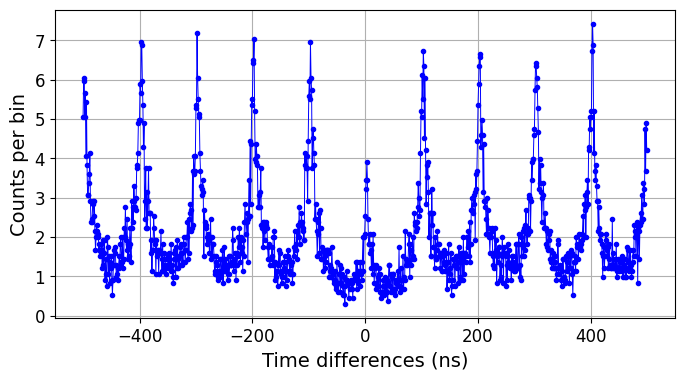

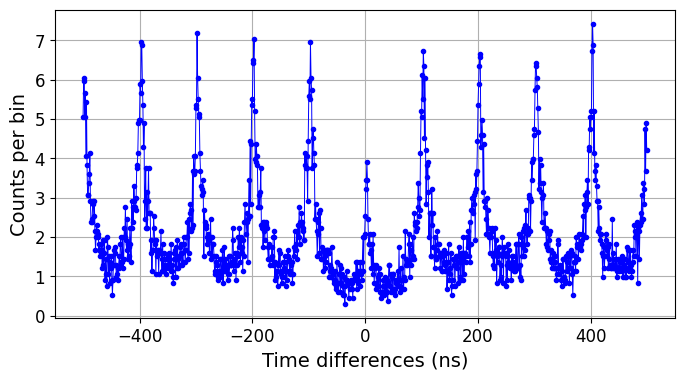

In [85]:
# Normalize counts 
capture_duration = np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]) * 1e12 # Capture duration in picoseconds
print("Capture duration (seconds): ", np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]))
counts_normalized = (ycorr  * capture_duration)/(bwcorr * counts_ch1 * counts_ch2) 

plot_data(xcorr, ycorr, width=8, height=4)
plot_data(xcorr, counts_normalized, width=8, height=4)
plot_data(xcorr, ycorr_norm, width=8, height=4)
    

In [22]:

# Define the fitting function: a * (1 - b * exp(- abs(tau - t0) / tau0)
def fitting_function(tau, t_0, tau_0, a, b):
    return a * (1 - b * np.exp(-np.abs(tau - t_0) / tau_0))

# Function to normalize counts and fit the data
def fit_noblinking(tau, counts):
    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function, tau, counts, p0=[0, 1e5, 1, 1])
    
    # Extract fitted parameters
    t_0, tau_0, a, b = popt
    
    # Calculate the standard deviations of the parameters
    perr = np.sqrt(np.diag(pcov))
    error_t0, error_tau0, error_a, error_b = perr

    # Print fitted parameters and their errors
    print(f"Fitted parameters:\n t₀ = {t_0:.3f} ± {error_t0:.3f} ps \n a = {a:.3f} ± {error_a:.3f} \n b = {b:.3f} ± {error_b:.3f}")
    print(f"Lifetime = {tau_0 / 1000:.2f} ± {error_tau0 / 1000:.2f} ns")
    
    # Calculate g²(τ = t₀)
    value_at_t_0 = fitting_function(t_0, t_0, tau_0, a, b)
    error_value_at_t_0 = np.sqrt(error_a**2 + error_b**2)  # Estimate error propagation
    print(f"g²(τ = t₀) = {value_at_t_0:.3f} ± {error_value_at_t_0:.3f}")
    
    return t_0, tau_0, a, b

# Function to plot the normalized data and the fitted curve
def plot_fit_noblinking(tau, counts, t_0, tau_0, a, b, width=10, height=6):
    # Create the plot
    plt.figure(figsize=(width, height))
    
    # Plot normalized data
    plt.plot(tau, counts, marker='o', linestyle='-', color='b', label='Normalized Data', markersize=3, linewidth=0.7)
    plt.title('Normalized auto-correlation graph')
    
    # Generate the fitted curve
    tau_fine = np.linspace(min(tau), max(tau), 10000)
    fitted_curve = fitting_function(tau_fine, t_0, tau_0, a, b)
    
    # Plot fitted curve
    plt.plot(tau_fine, fitted_curve, 'r-', label=f'Fit: t₀={t_0:.2f}ps, τ₀={tau_0:.2f}ps, g²(τ = t₀) = {a-b:.3f}')
    
    # Add title and labels
    plt.title('Normalized auto-correlation graph')
    plt.xlabel('Time differences (ps)')
    plt.ylabel('Normalized Counts')
    #plt.legend()
    plt.grid(True)
    plt.show()


In [23]:
# Define the fitting function: 1 - C * exp(abs(tau - t0) / tau0)
def fitting_function_blinking(tau, t_0, tau_0, p):
    return 1 - ((1-p)/p) * np.exp(-np.abs(tau - t_0) / tau_0)

# Function to normalize counts and fit the data
def fit_blinking(tau, counts):    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function_blinking, tau, counts, p0=[0, 1e5, 1])
    
    # Extract fitted parameters
    t_0, tau_0, p = popt
    
    # Calculate the standard deviations of the parameters
    perr = np.sqrt(np.diag(pcov))
    error_t0, error_tau0, error_p = perr

    # Print fitted parameters and their errors
    print(f"Fitted parameters: t₀ = {t_0:.2f} ± {error_t0:.2f} ps")
    print(f"Lifetime = {tau_0 / 1000:.2f} ± {error_tau0 / 1000:.2f} ns")
    print(f"p = {p:.2f} ± {error_p:.2f}")
    
    # Calculate g²(τ = t₀)
    value_at_t_0 = fitting_function_blinking(t_0, t_0, tau_0, p)
    error_value_at_t_0 = error_p/(p**2)  # Estimate error propagation
    print(f"g²(τ = t₀) = {value_at_t_0:.3f} ± {error_value_at_t_0:.3f}")
    
    return t_0, tau_0, p

# Function to plot the normalized data and the fitted curve
def plot_fit_blinking(tau, counts, t_0, tau_0, p, width=10, height=6):
    # Create the plot
    plt.figure(figsize=(width, height))
    
    # Plot normalized data
    plt.plot(tau, counts, marker='o', linestyle='-', color='b', label='Normalized Data', markersize=3, linewidth=0.7)
    plt.title('Normalized auto-correlation graph')
    
    # Generate the fitted curve
    tau_fine = np.linspace(min(tau), max(tau), 10000)
    fitted_curve = fitting_function_blinking(tau_fine, t_0, tau_0, p)
    
    # Plot fitted curve
    value_at_t_0 = fitting_function_blinking(t_0, t_0, tau_0, p)
    plt.plot(tau_fine, fitted_curve, 'r-', label=f'Fit: t₀={t_0:.2f}ps, τ₀={tau_0:.2f}ps, g²(τ = t₀) = {value_at_t_0:.3f}')
    
    # Add title and labels
    plt.title('Normalized auto-correlation graph')
    plt.xlabel('Time differences (ps)')
    plt.ylabel('Normalized Counts')
    plt.legend()
    plt.grid(True)
    plt.show()

Fitted parameters:
 t₀ = 2363.267 ± 207.990 ps 
 a = 1.351 ± 0.002 
 b = 0.859 ± 0.044
Lifetime = 5.83 ± 0.42 ns
g²(τ = t₀) = 0.190 ± 0.044


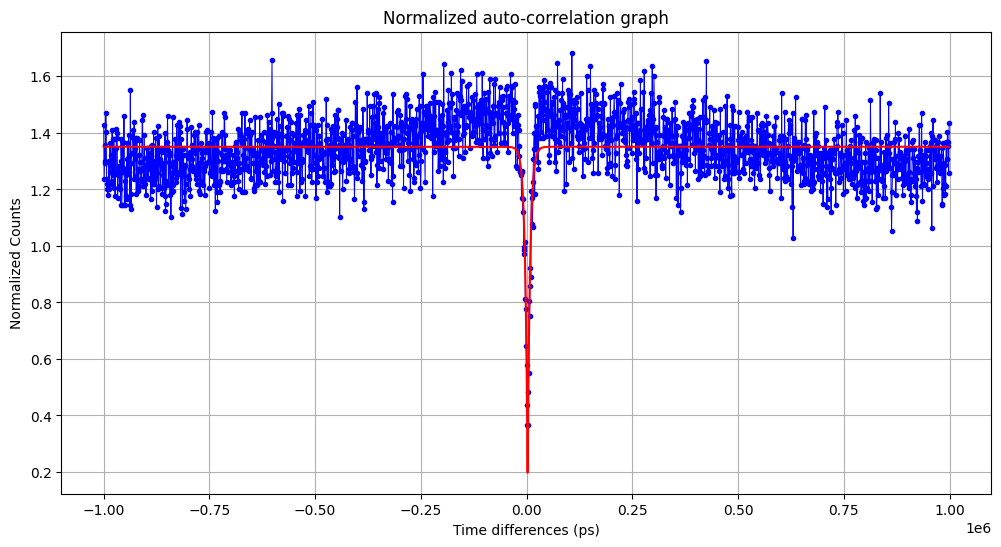

Fitted parameters: t₀ = -59973.31 ± 17232.74 ps
Lifetime = 2424.97 ± 146.15 ns
p = 1.72 ± 0.02
g²(τ = t₀) = 1.420 ± 0.005


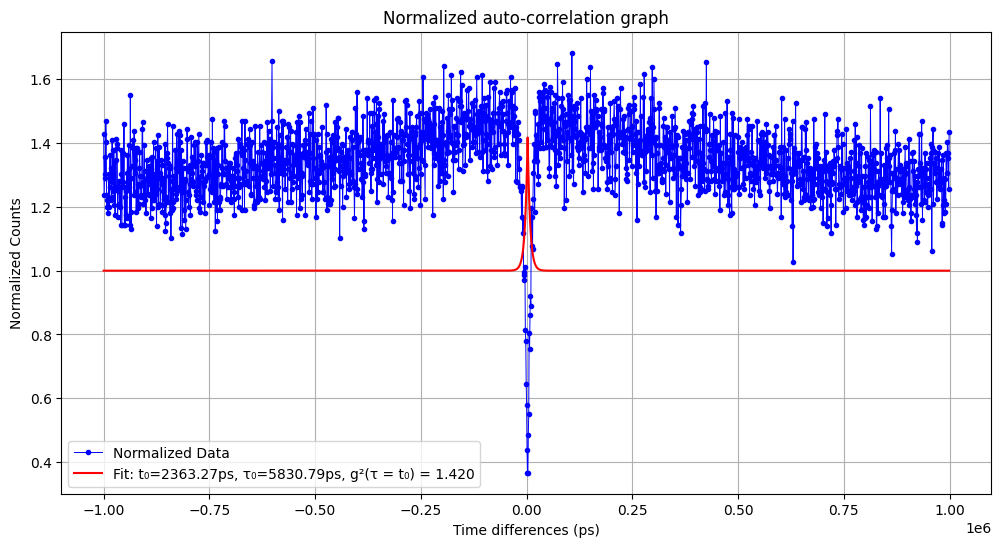

In [24]:
t_0, tau_0, a, b = fit_noblinking(xcorr, counts_normalized)
# Plot the normalized data and the fitted curve
plot_fit_noblinking(xcorr, counts_normalized, t_0, tau_0, a, b, width=12, height=6)
    
t_0_blinking, tau_0_blinking, p = fit_blinking(xcorr, counts_normalized)
# Plot the normalized data and the fitted curve
plot_fit_blinking(xcorr, counts_normalized, t_0, tau_0, p, width=12, height=6)

C:\Users\HP\AppData\Local\Temp\ipykernel_15572\2071120053.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


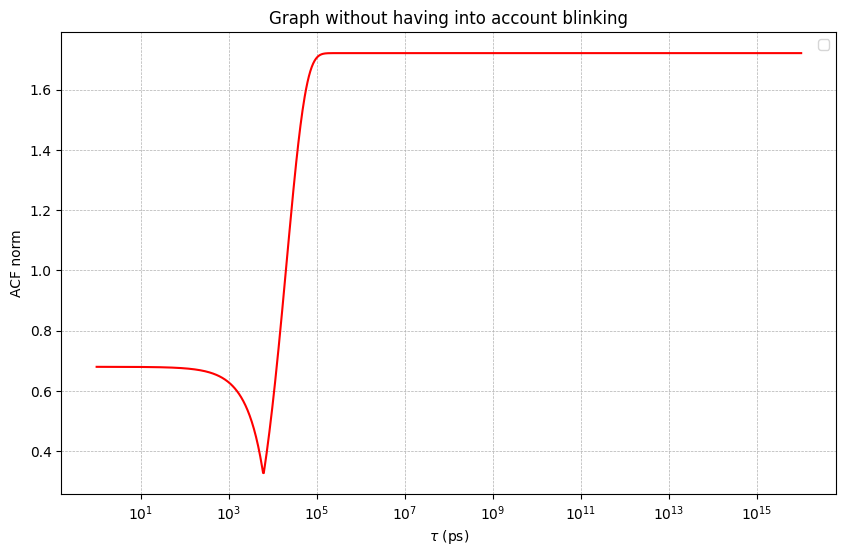

C:\Users\HP\AppData\Local\Temp\ipykernel_15572\2071120053.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


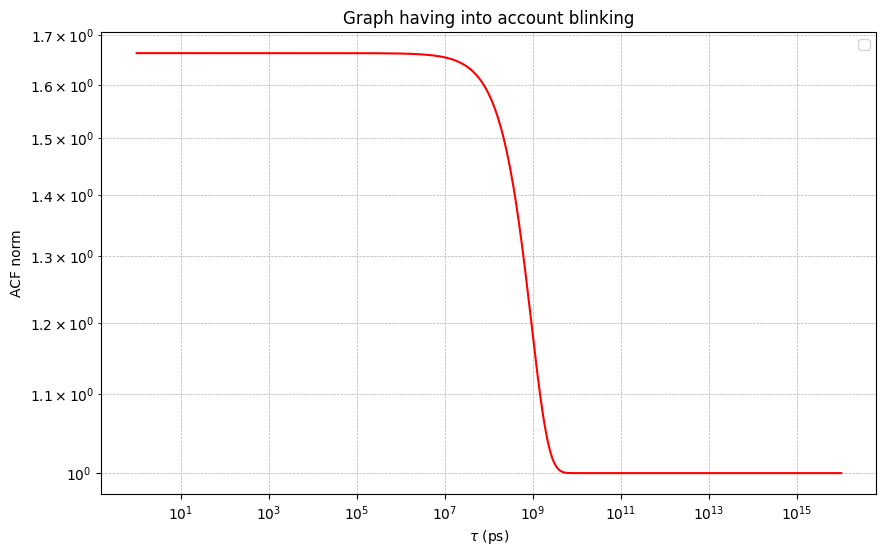

In [18]:
# Rango de tau: desde 10e-9 hasta 10e3
tau_values = np.logspace(0, 16, 1000)  # Espaciado logarítmico

# Calcula los valores de la función sin blinking
fitting_values = fitting_function(tau_values, t_0, tau_0, a, b)
# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(tau_values, fitting_values, color='r')
plt.xscale('log')
plt.title('Graph without having into account blinking')
plt.xlabel(r'$\tau$ (ps)')
plt.ylabel('ACF norm')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

# Calcula los valores de la función con blinking
fitting_values = fitting_function_blinking(tau_values, t_0_blinking, tau_0_blinking, p)
# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(tau_values, fitting_values, color='r')
plt.xscale('log')
plt.yscale('log')
plt.title('Graph having into account blinking')
plt.xlabel(r'$\tau$ (ps)')
plt.ylabel('ACF norm')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()